<a href="https://colab.research.google.com/github/HakanBayazitHabes/kebAI_Detection_CNN/blob/master/kabAI_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evrişimli Sinir Ağları(CNN) ile Pişmişlik Düzeyi Tespiti

## 1) İş Problemi (Business Problem)


## 2) Veriyi Anlamak(Data Understanding)

### 2.1) Gerekli Kütüphanelerin Import İşlemleri


In [3]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc,f1_score

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint # Checkpointler eğitim aşamsında kullanıcaz
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D,BatchNormalization, Activation,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

### 2.2) Veri Setinin Okunması



1.   Google Colab NoteBook ile Google Drive hesabının eşleştirilmesi
2.   Veri setinin Google Drive'a yüklenmesi ve adresiinin notebook'a gösterilmesi
3.   Veri setini okuyacak fonksiyonun tanımlanması

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Drive'da bu veri setinde yer alan görüntülerin olduğu path bilgisinin tutulması
dir_path = '/content/drive/MyDrive/KebAI/Images'

In [7]:
# Target size ve label Etiket Değerlerinin Belirlenmesi

target_size = (224, 224)

kebab_labels = {'cooked': 0, 'uncooked': 1}

In [8]:
def load_datasets(path):
  """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

    Parametreler:

    path : Görsellerin bulunduğu dizini ifade eder.

    return:

    x: Görüntülere ait matris bilgilerini tutar.

    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
  """

  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamktadır.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    # Belirlenen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    # Okunan görüntler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirlirler.
    img = cv2.resize(img, target_size)

    # Ölçeklendriilen görüntüler x listesine eklenir.
    x.append(img)

    # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı label'ı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    # Yakalanan labelların sayısal değer karşılıklarının olduğu kebab_labels sözlüğü içerisinden gönderilen key
    # değerine karşılık value değeri alınarak label oluşturulur.
    labels.append(kebab_labels[label])

  # Veri seti random bir şekilde karıştırılır.
  x, labels = shuffle(x, labels, random_state = 42)

  # Boyut ve sınıf bilgisi raporlanmaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)} ")

  return x, labels


In [9]:
x, labels = load_datasets(dir_path)

X boyutu: (1212, 224, 224, 3)
Label sınıf sayısı: 2 Gözlem sayısı: 1212 


In [10]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


## 3) Veriyi Hazırlamak (Data Preparation)

In [11]:
"""from sklearn.model_selection import train_test_split
batch_size=120
target_size=(224,2)
# Train seti ve test seti için ayırın (validation setini çıkararak)
x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify=labels)

# Train seti için ImageDataGenerator oluşturun
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Test seti için ImageDataGenerator oluşturun
test_datagen = ImageDataGenerator(rescale=1./255)

# Train seti için generator
train_generator = train_datagen.flow(np.array(x_train), np.array(y_train),
                                     target_size=target_size,
                                     class_mode='binary',  # İkili sınıflandırma
                                     subset = 'training',
                                     batch_size=batch_size)

# Test seti için generator
test_generator = test_datagen.flow(np.array(x_test), np.array(y_test),
                                   target_size=target_size,
                                   class_mode='binary',
                                   batch_size=batch_size,
                                   shuffle=False,
                                   subset = 'validation')  # Test seti
"""


"""

train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.2, # Test veri setinin oranı olarak ifade edilmektedir.
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# Test veri seti için bir generator tanımlıyoruz
test = ImageDataGenerator(rescale=1./255,
                          validation_split=0.2,
                          )
"""


train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.2, # Test veri setinin oranı olarak ifade edilmektedir.
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

test = ImageDataGenerator(rescale=1./255,
                          validation_split=0.2,
                          )


In [12]:

train_generator= train.flow_from_directory(directory=dir_path,
                                           target_size=(target_size),
                                           batch_size=64,
                                           class_mode='binary',
                                           shuffle=True,
                                           subset = 'training')
# class_mode daki categorical birden fazla classımızın olduğunu anlayacaktır. İkili sınıflandırma yapsaydık binary ifadesi kullanacaktık.

test_generator = test.flow_from_directory(directory=dir_path,
                                          target_size = (target_size),
                                          batch_size=64,
                                          class_mode='binary',
                                          subset = 'validation',
                                          shuffle=False)


# batch_size ile test setinin boyut bilgisini girmiş olduk.

Found 970 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


### 3.1) Veri Setinden Örnekler Gösterilmesi

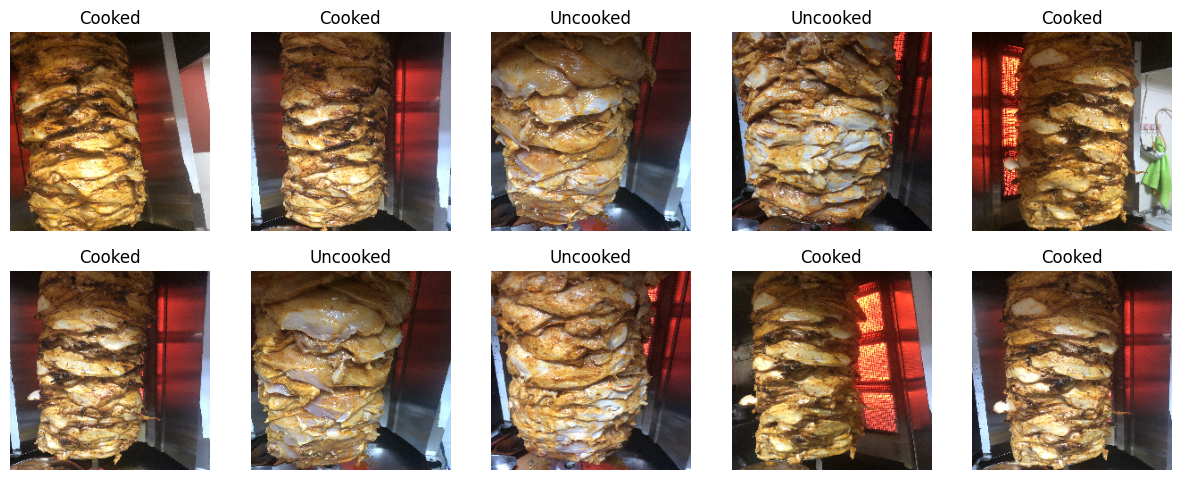

In [13]:
"""plt.figure(figsize=(10,10))

for n in range(5):
  img, label = test_generator.next()
  ax = plt.subplot(5,5,n+1)
  print(img.shape)
  plt.imshow(img[n])
  print(label[n])
  plt.axis('off')
  plt.show()
"""
plt.figure(figsize=(15,15))
for n in range(10):
  img, label = test_generator.next()
  ax = plt.subplot(5,5,n+1)
  plt.imshow(img[n])
  plt.title(np.array(list(kebab_labels.keys()))[to_categorical(label, num_classes = 2)[n]==1][0].title())
  plt.axis('off')


## 4) Modelleme (Modeling)

### 4.1) Sıfırdan CNN Modeli Kurma


*   Sequential
*   Evrişim Katmanı (Convolution Layer, Conv2D)
*   Havuzlama Katmanı (Pooling Layer)
*   Aktivasyon Fonksiyonu Katmanı (Activation Layer)
*   Flattening Katmanı
*   Dense Katmanı
*   Dropout Katmanı

In [ ]:
model = Sequential()

# 1. KATMAN
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))


model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(rate=0.2))

# 2. KATMAN




# 5. KATMAN
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(rate=0.2))


### TAM BAĞIMSIZ KATMANI
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))

### ÇIKIŞ KATMANI

model.add(Dense(1, activation='sigmoid'))


### 4.2 Model Özeti

In [ ]:
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_251 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_251 (B  (None, 224, 224, 32)      128       
 atchNormalization)                                              
                                                                 
 dropout_348 (Dropout)       (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_173 (MaxPool  (None, 112, 112, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_252 (Conv2D)         (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_252 (B  (None, 112, 112, 32)    

### 4.3) Optimizasyon ve Değerlerndirme Metriklerinin Ayarlanması

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])


In [ ]:
root = '/content/drive/MyDrive/KebAI/'

callbacks = [
             CSVLogger("/content/drive/MyDrive/KebAI/training.csv", separator="-"),
             EarlyStopping(monitor='val_loss', patience=27, verbose=1, mode="min"),
             ModelCheckpoint(filepath= root + 'save_model_weights/kabAI_model.h5', verbose=2, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False),
             History()
             ]
# en başarılı ağırlıkları kaydet
# EarlyStopping = Model ezberleyeme başlamıssa erkenden durdurur.

### 4.4) Modelin Eğitilmesi

In [ ]:
# Model çalıştırılamsı
import pickle

#history = model.fit(train_generator,epochs=4,verbose=1,workers=4,validation_data=test_generator,callbacks=callbacks)


history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              steps_per_epoch=train_generator.samples//64,
                              validation_steps=test_generator.samples//64
                              )
model.save(root + 'data/')
model.save_weights('/content/drive/MyDrive/KebAI/save_model_weights/')
#model.save_weights(root + 'data/save_model_weights/kabAI_model_weights.h5')


with open('/content/drive/MyDrive/KebAI/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# save model to json
model_json = model.to_json()
with open('/content/drive/MyDrive/KebAI/save_model_weights/kabAI_model.json', 'w') as json_file:
  json_file.write(model_json)

import json
with open('/content/drive/MyDrive/KebAI/save_model_weights/history.json', 'w') as history_file:
  json.dump(history.history, history_file)




Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.5230 - precision_4: 0.8140 - recall_4: 0.8082 - acc: 0.7660
Epoch 1: val_loss improved from inf to 0.71142, saving model to /content/drive/MyDrive/KebAI/save_model_weights/kabAI_model.h5
15/15 [==============================] - 203s 13s/step - loss: 0.5230 - precision_4: 0.8140 - recall_4: 0.8082 - acc: 0.7660 - val_loss: 0.7114 - val_precision_4: 0.5260 - val_recall_4: 1.0000 - val_acc: 0.5260
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.3281 - precision_4: 0.8835 - recall_4: 0.8991 - acc: 0.8631
Epoch 2: val_loss did not improve from 0.71142
15/15 [==============================] - 184s 12s/step - loss: 0.3281 - precision_4: 0.8835 - recall_4: 0.8991 - acc: 0.8631 - val_loss: 0.9124 - val_precision_4: 0.5260 - val_recall_4: 1.0000 - val_acc: 0.5260
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.2180 - precision_4: 0.9342 - recall_4: 0.9358 - acc: 0.9194
Epoch 3: va

In [ ]:
ls /content/drive/MyDrive/KebAI/data

assets/  fingerprint.pb  keras_metadata.pb  saved_model.pb  variables/


In [121]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/KebAI/data')

new_model.summary()


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_251 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_251 (B  (None, 224, 224, 32)      128       
 atchNormalization)                                              
                                                                 
 dropout_348 (Dropout)       (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_173 (MaxPool  (None, 112, 112, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_252 (Conv2D)         (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_252 (B  (None, 112, 112, 32)    

In [149]:
# Test seti içerisinde hangi kategoriden kaç örnek var

from collections import Counter

# Test veri kümesinin sınıflarını alın
class_indices = test_generator.class_indices

# Her sınıfın adını ve indeksini görüntüleyin
print("Class Indices:", class_indices)

# Test veri kümesindeki toplam örnek sayısı
total_samples = test_generator.samples
print("Total Samples:", total_samples)

# Test veri kümesindeki sınıfların gerçek adlarını ve kaç örnek içerdiğini sayın
class_counts = Counter(test_generator.classes)
for class_name, class_index in class_indices.items():
    count = class_counts[class_index]
    print(f"Class: {class_name}, Index: {class_index}, Count: {count} samples")


Class Indices: {'cooked': 0, 'uncooked': 1}
Total Samples: 242
Class: cooked, Index: 0, Count: 91 samples
Class: uncooked, Index: 1, Count: 151 samples


### 4.5) Accuracy ve Loss Grafikleri

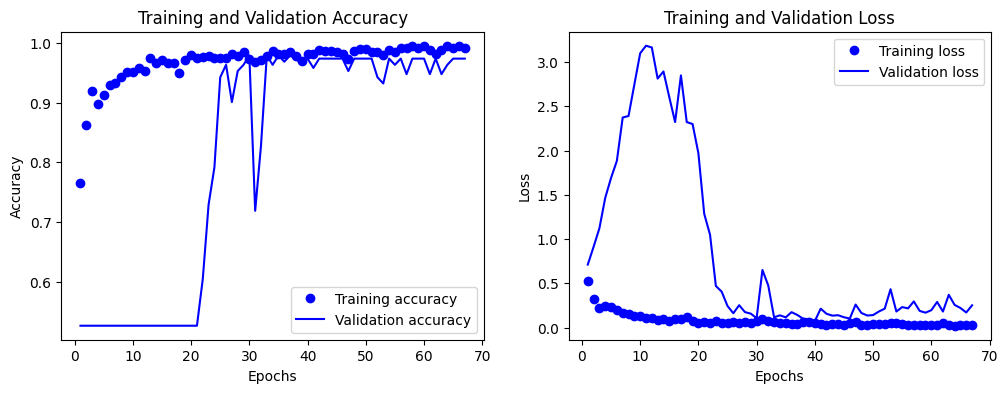

In [150]:
# Eğitim boyunca epoch-acc ve epoch-loss değeri çıktısı

import pickle
import matplotlib.pyplot as plt

# History nesnesini dosyadan yükleyin
with open('/content/drive/MyDrive/KebAI/history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Eğitim sırasında elde edilen metrik değerlere erişin
loaded_accuracy = loaded_history['acc']
loaded_loss = loaded_history['loss']
loaded_val_accuracy = loaded_history['val_acc']
loaded_val_loss = loaded_history['val_loss']

# Epoch-accuracy ve epoch-loss grafiklerini oluşturun
epochs = range(1, len(loaded_accuracy) + 1)

plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, loaded_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, loaded_val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loaded_loss, 'bo', label='Training loss')
plt.plot(epochs, loaded_val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 5) Değerlendirme (Evaluation)

In [152]:
# SavedModel dosyasını yükle
#saved_model_path = '/content/drive/MyDrive/KebAI/save_model_weights/kabAI_model.h5'
#loaded_model = tf.keras.models.
saved_model_path = '/content/drive/MyDrive/KebAI/data'
loaded_model = tf.keras.models.load_model(saved_model_path)


4/4 [==============================] - 24s 6s/step


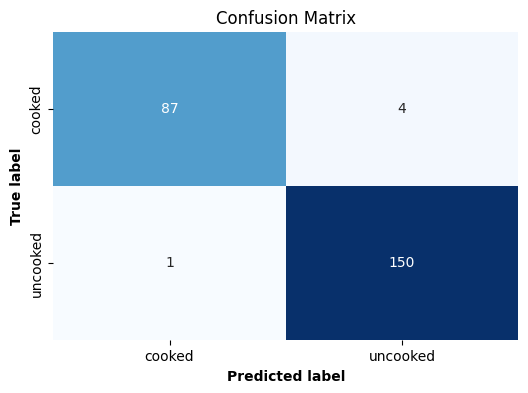

In [153]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test verileri üzerinde tahminlerde bulun
predictions = loaded_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)  # 0.5'ten büyükse 1, küçükse 0

# Gerçek etiketleri alın
true_labels = test_generator.classes

# Sınıf adlarını tanımlayın
class_names = ['cooked', 'uncooked']

# Confusion matrix'i oluştur
cm = confusion_matrix(true_labels, predicted_classes)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', fontweight="bold")
plt.ylabel('True label', fontweight="bold")
plt.show()


In [158]:
loss, precision, recall, acc = loaded_model.evaluate(test_generator, batch_size=64)

print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.f%%" % (100.0 * loss))
print("\nTest pricision : %.1f%%" % (100.0 * precision))
print("\nTest recall : %.1f%%" % (100.0 * recall))
# F1 Score
f1 = f1_score(true_labels, predicted_classes)
print("\nTest F1 Score : %.1f%%" % (100.0 * f1))

16/16 [==============================] - 121s 8s/step - loss: 0.0090 - precision_4: 0.9950 - recall_4: 0.9967 - acc: 0.9948

Test Accuracy: 99.5%

Test loss: 1%

Test pricision : 99.5%

Test recall : 99.7%

Test F1 Score : 98.4%


In [160]:
loss, precision, recall, acc = loaded_model.evaluate(train_generator, batch_size=64)

print("\nTrain Accuracy: %.1f%%" % (100.0 * acc))
print("\nTrain loss: %.f%%" % (100.0 * loss))
print("\nTrain pricision : %.1f%%" % (100.0 * precision))
print("\nTrain recall : %.1f%%" % (100.0 * recall))
# F1 Score
f1 = f1_score(true_labels, predicted_classes)
print("\nTrain F1 Score : %.1f%%" % (100.0 * f1))

16/16 [==============================] - 111s 7s/step - loss: 0.0104 - precision_4: 0.9967 - recall_4: 0.9967 - acc: 0.9959

Train Accuracy: 99.6%

Train loss: 1%

Train pricision : 99.7%

Train recall : 99.7%

Train F1 Score : 98.4%


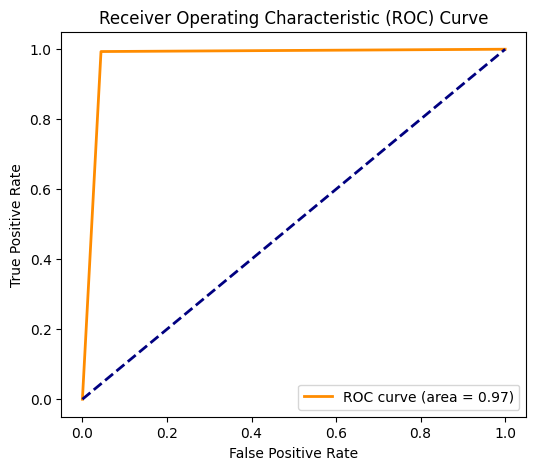

In [155]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Modelin Kullanılması / Test Edilmesi

In [156]:
kebab_labels = { 0 : 'cooked', 1: 'uncooked'}

In [157]:
from tensorflow.keras.preprocessing import image

# Dışarıdan eklenen tek bir test örneği dosyasının yolu
external_image_path = '/content/drive/MyDrive/KebAI/Images/cooked/IMG_2531.jpg'

# Resmi modelin beklentilerine uygun şekilde yükleyin
img = image.load_img(external_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalizasyon

# Model üzerinde tahmin yapın
predictions = loaded_model.predict(img_array)
print(predictions)
# Tahmin sonuçlarını yazdırın
if predictions[0, 0] > 0.5:
    print("Model tarafından uncooked (sınıf 1) olarak tahmin edildi.")
else:
    print("Model tarafından cooked (sınıf 0) olarak tahmin edildi.")

1/1 [==============================] - 0s 106ms/step
[[2.1429306e-08]]
Model tarafından cooked (sınıf 0) olarak tahmin edildi.
